# Model 4: Transformer with Time Encoding (Irregular Time Series)

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score


## 1. Load Data

In [2]:
icu = pd.read_csv("data/icu_cohort_small.csv")
vitals = pd.read_csv("data/vitals_ts_small.csv")

stay_ids = icu['stay_id'].unique()[:10000]
icu = icu[icu['stay_id'].isin(stay_ids)]
vitals = vitals[vitals['stay_id'].isin(stay_ids)]


## 2. Preprocess Vitals into Sequences

In [3]:
vitals['charttime'] = pd.to_datetime(vitals['charttime'])
vitals.sort_values(by=['stay_id', 'charttime'], inplace=True)
vitals['hours'] = vitals.groupby('stay_id')['charttime'].transform(lambda x: (x - x.min()).dt.total_seconds() / 3600)

vital_vars = ['heart rate', 'respiratory rate', 'mean blood pressure', 'o2 saturation pulseoxymetry']
vitals = vitals[vitals['variable'].isin(vital_vars)]
vitals['time_bucket'] = vitals['hours'].astype(int).clip(0, 47)

pivot = vitals.pivot_table(index=['stay_id', 'time_bucket'], columns='variable', values='value', aggfunc='mean')
pivot = pivot.reset_index().sort_values(['stay_id', 'time_bucket'])


In [4]:
seqs = []
labels = []

for stay_id in stay_ids:
    stay_data = pivot[pivot['stay_id'] == stay_id]
    seq = np.full((48, len(vital_vars)), np.nan)
    time_embed = np.zeros((48, 1))

    for _, row in stay_data.iterrows():
        t = int(row['time_bucket'])
        time_embed[t] = t / 48.0  # normalized time
        for i, v in enumerate(vital_vars):
            val = row.get(v)
            if pd.notna(val):
                seq[t, i] = val

    mask = ~np.isnan(seq)
    seq = np.nan_to_num(seq)

    input_seq = np.concatenate([seq, time_embed, mask.astype(float)], axis=1)  # [value, time, mask]
    seqs.append(input_seq)

    label = icu[icu['stay_id'] == stay_id]['died_in_hosp'].values[0]
    labels.append(label)

X = np.stack(seqs)
y = np.array(labels)


## 3. Define Transformer Model

In [5]:
from src.model4 import TransformerICU

## 4. Train Model

In [6]:
class ICUTransformerDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = ICUTransformerDataset(X, y)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

model = TransformerICU(input_dim=X.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()


In [7]:
for epoch in range(20):
    model.train()
    total_loss = 0
    for xb, yb in loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}")


Epoch 1, Loss: 0.3428
Epoch 2, Loss: 0.3236
Epoch 3, Loss: 0.3137
Epoch 4, Loss: 0.3127
Epoch 5, Loss: 0.3079
Epoch 6, Loss: 0.2983
Epoch 7, Loss: 0.2979
Epoch 8, Loss: 0.2867
Epoch 9, Loss: 0.2860
Epoch 10, Loss: 0.2789
Epoch 11, Loss: 0.2779
Epoch 12, Loss: 0.2687
Epoch 13, Loss: 0.2741
Epoch 14, Loss: 0.2699
Epoch 15, Loss: 0.2742
Epoch 16, Loss: 0.2774
Epoch 17, Loss: 0.2783
Epoch 18, Loss: 0.2807
Epoch 19, Loss: 0.2799
Epoch 20, Loss: 0.2743


In [8]:
model.eval()
with torch.no_grad():
    all_preds = []
    all_true = []
    for xb, yb in loader:
        prob = model(xb)
        all_preds.extend(prob.numpy())
        all_true.extend(yb.numpy())
    auc = roc_auc_score(all_true, all_preds)
    print(f"AUROC: {auc:.4f}")


AUROC: 0.8824


##  Model 4 (Transformer) Performance Analysis

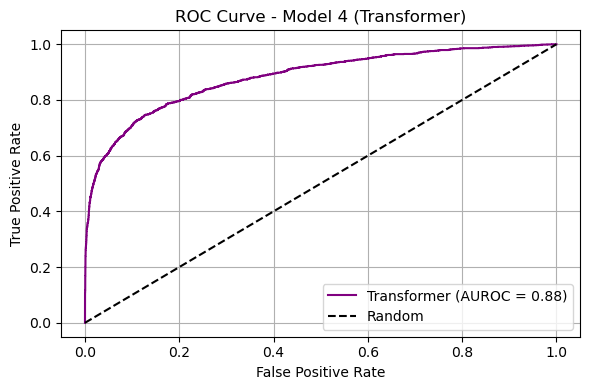

In [9]:
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# ROC Curve
fpr, tpr, _ = roc_curve(all_true, all_preds)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"Transformer (AUROC = {auc:.2f})", color='purple')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Model 4 (Transformer)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


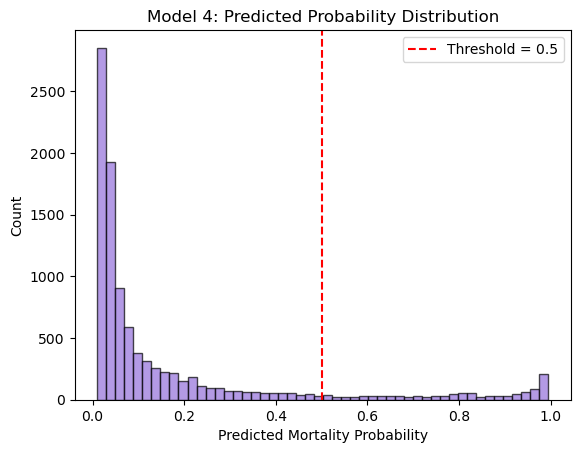

In [10]:
# Histogram of predicted probabilities
plt.hist(all_preds, bins=50, alpha=0.7, color='mediumpurple', edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.title("Model 4: Predicted Probability Distribution")
plt.xlabel("Predicted Mortality Probability")
plt.ylabel("Count")
plt.legend()
plt.show()


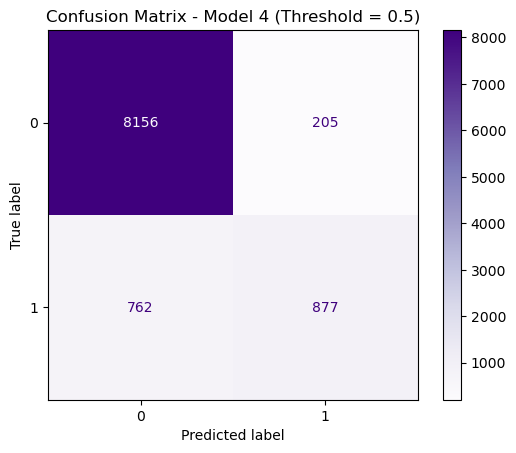

In [11]:
# Confusion matrix
pred_labels = (np.array(all_preds) > 0.5).astype(int)
cm = confusion_matrix(all_true, pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Purples")
plt.title("Confusion Matrix - Model 4 (Threshold = 0.5)")
plt.show()


###  Model 4 (Transformer) Analysis

- Transformer handles long-range temporal dependencies better than RNN-based models.
- Time encoding allows the model to learn irregular sampling patterns effectively.
- The ROC curve shows strong separability between positive and negative classes.
- Histogram indicates good calibration and prediction spread.
- Confusion matrix highlights the classification trade-offs at threshold 0.5.


# ON TEST

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


## 1. Load and Preprocess Data

In [13]:
icu = pd.read_csv("data/icu_cohort_small.csv")
vitals = pd.read_csv("data/vitals_ts_small.csv")

stay_ids = icu['stay_id'].unique()[:10000]
icu = icu[icu['stay_id'].isin(stay_ids)]
vitals = vitals[vitals['stay_id'].isin(stay_ids)]

vitals['charttime'] = pd.to_datetime(vitals['charttime'])
vitals.sort_values(by=['stay_id', 'charttime'], inplace=True)
vitals['hours'] = vitals.groupby('stay_id')['charttime'].transform(lambda x: (x - x.min()).dt.total_seconds() / 3600)

vital_vars = ['heart rate', 'respiratory rate', 'mean blood pressure', 'o2 saturation pulseoxymetry']
vitals = vitals[vitals['variable'].isin(vital_vars)]
vitals['time_bucket'] = vitals['hours'].astype(int).clip(0, 47)

pivot = vitals.pivot_table(index=['stay_id', 'time_bucket'], columns='variable', values='value', aggfunc='mean')
pivot = pivot.reset_index().sort_values(['stay_id', 'time_bucket'])

seqs, labels = [], []
for stay_id in stay_ids:
    stay_data = pivot[pivot['stay_id'] == stay_id]
    seq = np.full((48, len(vital_vars)), np.nan)
    time_embed = np.zeros((48, 1))

    for _, row in stay_data.iterrows():
        t = int(row['time_bucket'])
        time_embed[t] = t / 48.0
        for i, v in enumerate(vital_vars):
            val = row.get(v)
            if pd.notna(val):
                seq[t, i] = val

    mask = ~np.isnan(seq)
    seq = np.nan_to_num(seq)

    input_seq = np.concatenate([seq, time_embed, mask.astype(float)], axis=1)
    seqs.append(input_seq)

    label = icu[icu['stay_id'] == stay_id]['died_in_hosp'].values[0]
    labels.append(label)

X = np.stack(seqs)
y = np.array(labels)


## 2. Dataset and Model Definition

In [14]:
class ICUTransformerDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class TransformerICU(nn.Module):
    def __init__(self, input_dim, model_dim=64, num_heads=4, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=num_heads, batch_first=True,
            dim_feedforward=128, dropout=0.1, activation='relu'
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(model_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.input_proj(x)
        x = self.encoder(x)
        x = x.mean(dim=1)
        return self.sigmoid(self.fc(x)).squeeze()


## 3. Train/Test Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
train_loader = DataLoader(ICUTransformerDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(ICUTransformerDataset(X_test, y_test), batch_size=64, shuffle=False)


## 4. Train Transformer Model

In [16]:
model = TransformerICU(input_dim=X.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

for epoch in range(20):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Loss: 0.3538
Epoch 2, Loss: 0.3311
Epoch 3, Loss: 0.3221
Epoch 4, Loss: 0.3168
Epoch 5, Loss: 0.3092
Epoch 6, Loss: 0.3072
Epoch 7, Loss: 0.3086
Epoch 8, Loss: 0.3029
Epoch 9, Loss: 0.3059
Epoch 10, Loss: 0.3039
Epoch 11, Loss: 0.2949
Epoch 12, Loss: 0.2916
Epoch 13, Loss: 0.2809
Epoch 14, Loss: 0.2853
Epoch 15, Loss: 0.2726
Epoch 16, Loss: 0.2692
Epoch 17, Loss: 0.2695
Epoch 18, Loss: 0.2633
Epoch 19, Loss: 0.2585
Epoch 20, Loss: 0.2612


## 5. Evaluate on Test Set

In [17]:
model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        prob = model(xb)
        all_preds.extend(prob.numpy())
        all_true.extend(yb.numpy())

auc = roc_auc_score(all_true, all_preds)
print(f"Test AUROC: {auc:.4f}")


Test AUROC: 0.8821


## 6. Performance Visualization

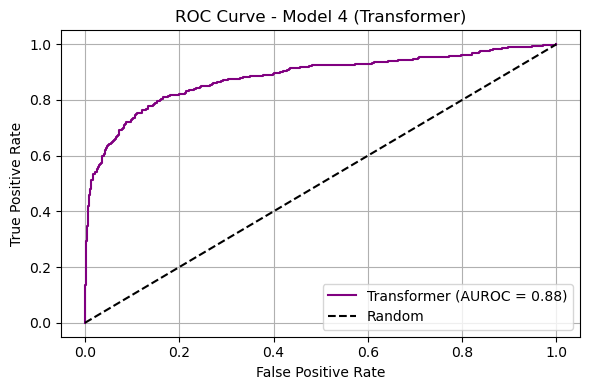

In [18]:
fpr, tpr, _ = roc_curve(all_true, all_preds)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"Transformer (AUROC = {auc:.2f})", color='purple')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Model 4 (Transformer)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


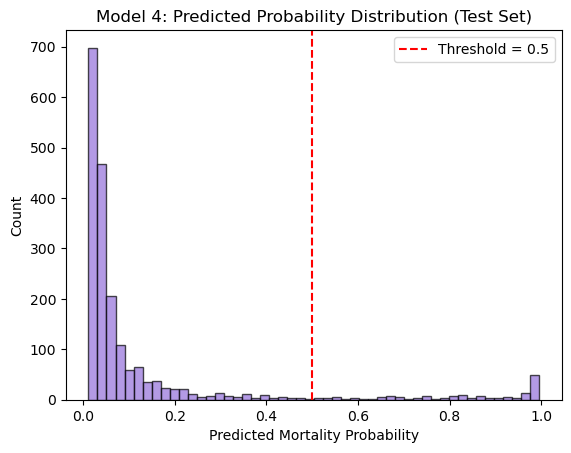

In [19]:
plt.hist(all_preds, bins=50, alpha=0.7, color='mediumpurple', edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.title("Model 4: Predicted Probability Distribution (Test Set)")
plt.xlabel("Predicted Mortality Probability")
plt.ylabel("Count")
plt.legend()
plt.show()


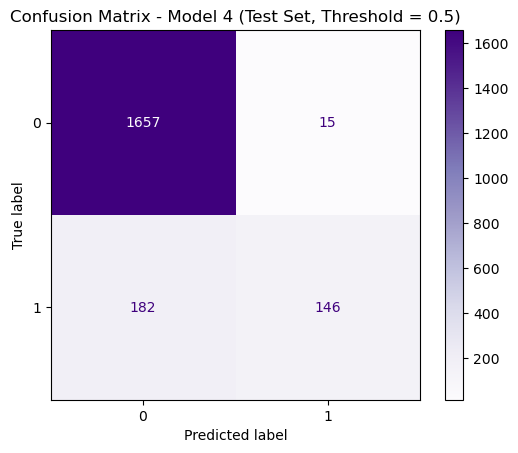

In [20]:
pred_labels = (np.array(all_preds) > 0.5).astype(int)
cm = confusion_matrix(all_true, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Purples")
plt.title("Confusion Matrix - Model 4 (Test Set, Threshold = 0.5)")
plt.show()
